In [1]:
!pip install scikit-learn
!pip install tensorflow
!pip install scikit-image
!pip install seaborn

In [60]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [61]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.linear_model import Perceptron
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier # neural network

In [62]:
from PIL import Image

In [63]:
#current working directory
cur_wd = os.getcwd()
print(cur_wd)


/work/MLDL_Exam


In [64]:
#our images are stored in two seperate folders:
os.listdir(os.path.join(cur_wd, 'archive'))

['test', '.DS_Store', 'train', 'augmented_train']

In [65]:
#inside each folder of images are further two subfolders dividing the pictures
os.listdir(os.path.join(cur_wd, 'archive', 'test'))

['Benign', '.DS_Store', 'Malignant']

In [66]:
#ensuring that we have access to the pictures
os.listdir(os.path.join(cur_wd, 'archive', 'test', 'Benign'))[:10]

['7028.jpg',
 '7293.jpg',
 '6630.jpg',
 '6437.jpg',
 '7056.jpg',
 '6927.jpg',
 '7090.jpg',
 '6605.jpg',
 '6506.jpg',
 '6469.jpg']

In [67]:
# Define the paths to your training and testing directories
train_dir = './archive/train/'
test_dir = './archive/test/'

In [68]:
#Values
IMG_HEIGHT = 224
IMG_WIDTH = 224
COLOR_CHANNELS = 3

In [69]:
from tqdm import tqdm
import numpy as np

def load_images(directory, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=32,
        color_mode='rgb',  # Specifies images are to be loaded in RGB mode
        class_mode='binary',  # or 'input' for unsupervised learning
        shuffle=False  # Important for PCA if you need to maintain label order
    )
    
    num_images = generator.samples
    # We calculate the total number of features per image (height x width x channels)
    data = np.zeros((num_images, target_size[0] * target_size[1] * 3))
    labels = np.zeros((num_images,))
    i = 0
    
    # Progress bar setup
    pbar = tqdm(total=num_images, desc="Loading images", unit="images")
    
    for x_batch, y_batch in generator:
        batch_size = x_batch.shape[0]
        for j in range(batch_size):
            # Flatten each image to a 1D array and store it in the data array
            data[i] = x_batch[j].flatten()
            labels[i] = y_batch[j]
            i += 1
            pbar.update(1)  # Update progress after each image is processed
        if i >= num_images:
            break
    
    pbar.close()

    indices = np.random.permutation(num_images)
    data = data[indices]
    labels = labels[indices]
    
    return data, labels


In [70]:
#Loading of the images
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

Found 11879 images belonging to 2 classes.


Loading images: 100%|██████████| 11879/11879 [00:18<00:00, 646.17images/s]


Found 2000 images belonging to 2 classes.


Loading images: 100%|██████████| 2000/2000 [00:02<00:00, 669.99images/s]


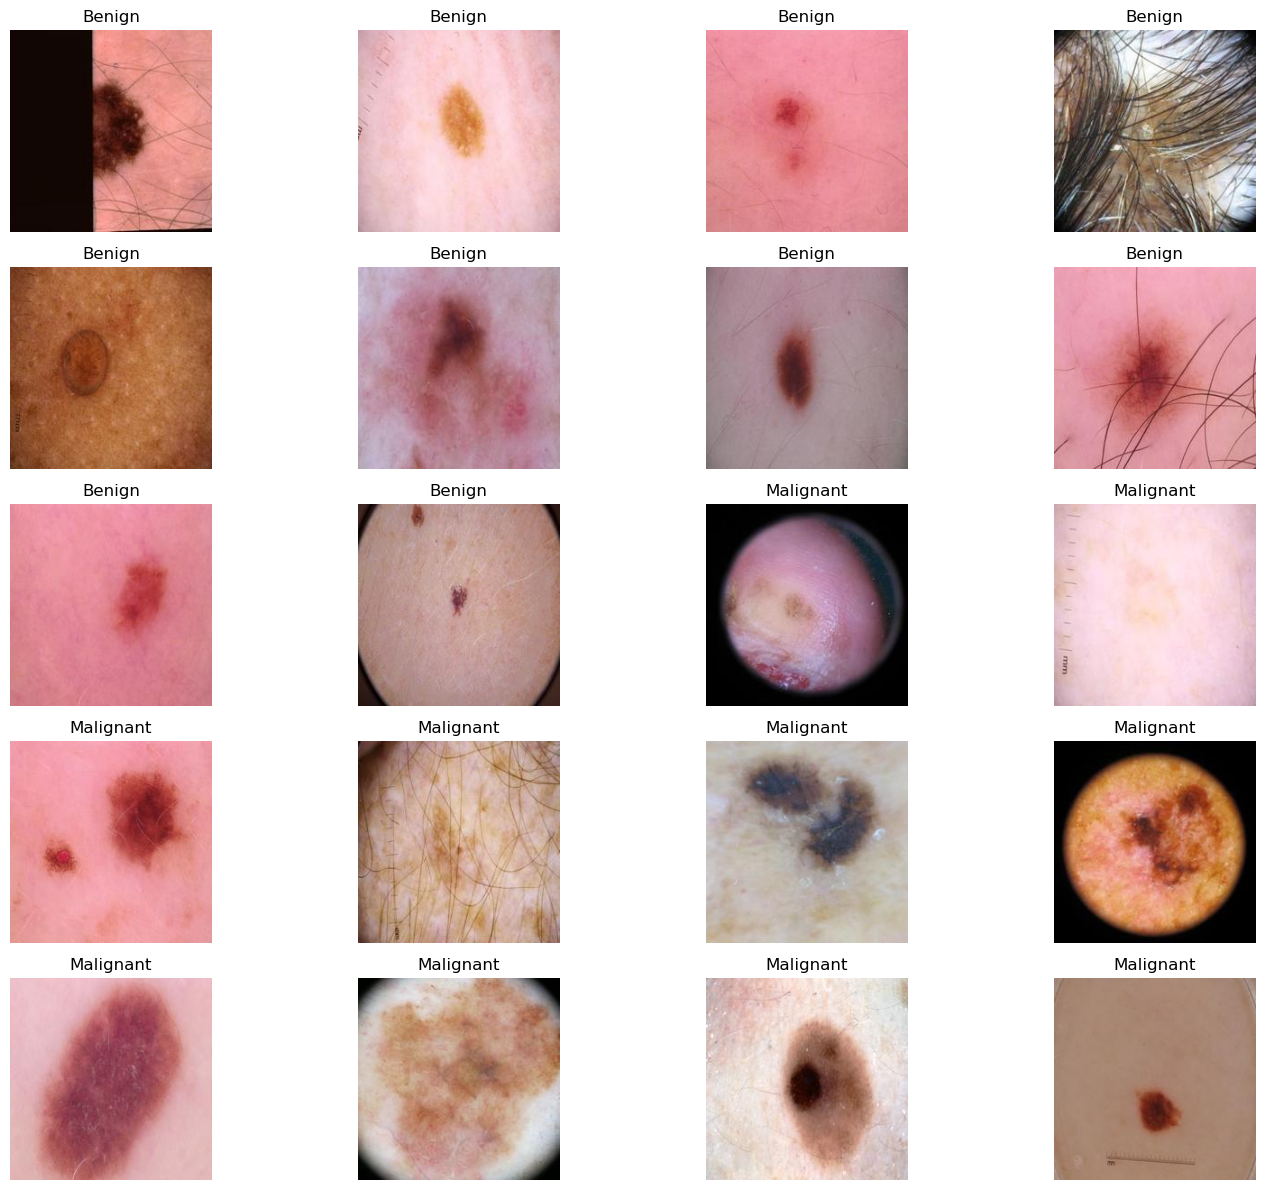

In [71]:
# Reshape images back to 224x224x3
X_train_reshaped = X_train.reshape((-1, IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS))

# Selecting 10 benign (first 10) and 10 malignant (from the rest)
benign_images = X_train_reshaped[:10]  # First 10 benign images
malignant_images = X_train_reshaped[-10:]  # Last 10 malignant images

# Combining selected images
selected_images = np.vstack([benign_images, malignant_images])

# Create labels corresponding to the selected images
labels = ['Benign']*10 + ['Malignant']*10  

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])  
    ax.set_title(labels[i])  # Adding the label as title to each subplot
    ax.axis('off')  # Turn off axis numbering
plt.tight_layout()
plt.show()


In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11879, 150528)
(11879,)
(2000, 150528)
(2000,)


In [73]:
check_images('archive/train/Benign')
check_images('archive/train/Malignant')
check_images('archive/test/Benign')
check_images('archive/test/Malignant')

Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG


In [17]:
def balance(y):
    benign_count = np.count_nonzero(y == 0)
    malignant_count = np.count_nonzero(y == 1)

    cat = ['Benign', 'Malignant']
    counts = [benign_count, malignant_count]
    total = sum(counts)

    plt.figure(figsize = (8, 5))
    bars = plt.bar(cat, counts, color = ['green', 'red'])
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Benign and Malignant Images')

    #adding pct to bars:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/total: .2%}',
            va = 'bottom',
            ha = 'center')

    plt.show()

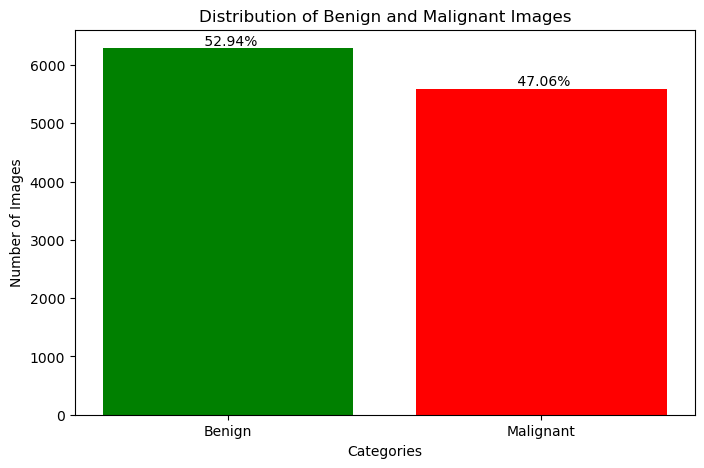

In [18]:
balance(y_train)

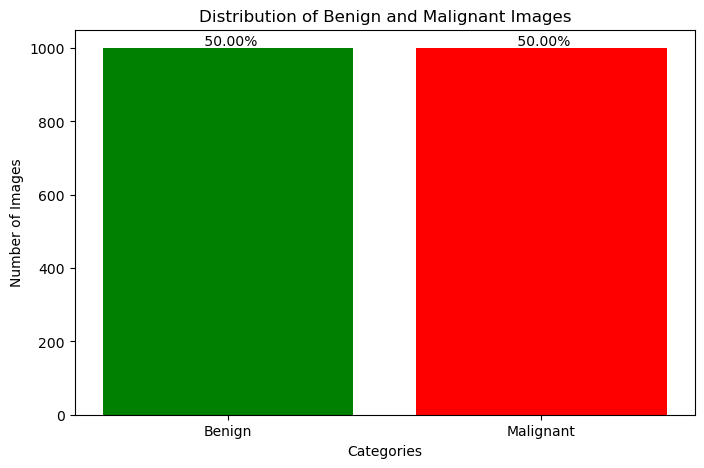

In [19]:
balance(y_test)

In [20]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # for example, retain 50 components
principal_components = pca.fit_transform(X_train)

# Explained variance can help determine the number of components to retain
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Explained variance ratio: 0.9500694951940353


In [21]:
reconstructed_images = pca.inverse_transform(principal_components)

In [22]:
print("Shape of principal components:", principal_components.shape)
print("Shape of reconstructed images:", reconstructed_images.shape)


Shape of principal components: (11879, 67)
Shape of reconstructed images: (11879, 150528)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


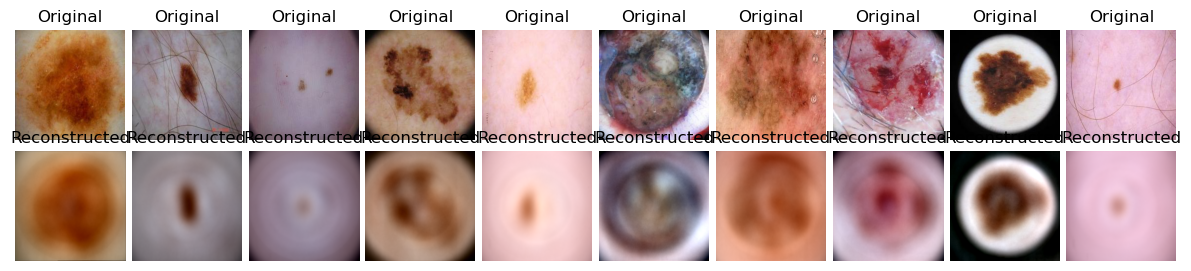

In [24]:
# Reshape the inverse-transformed data (reconstructed images) back to its original dimensions
reconstructed_images_reshaped = reconstructed_images.reshape(-1, IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)

# Number of images to display
num_images_to_display = 10

# Plotting
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 3))  # Adjusting size for better view

for i in range(num_images_to_display):
    # Display original images
    ax = axes[0, i]  # First row for original images
    ax.imshow(X_train_reshaped[i]) 
    ax.set_title("Original")
    ax.axis('off')  # Turn off axis numbering
    
    # Display reconstructed images
    ax = axes[1, i]  # Second row for reconstructed images
    ax.imshow(reconstructed_images_reshaped[i])
    ax.set_title("Reconstructed")
    ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Adjusting spacing to minimize gaps
plt.show()


In [25]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by each component:", explained_variance_ratio)

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative variance explained by components:", cumulative_variance)

Explained variance ratio by each component: [4.62313096e-01 1.90831721e-01 5.20196016e-02 3.95956097e-02
 2.44854096e-02 2.31026099e-02 1.99364755e-02 1.33318440e-02
 1.18859410e-02 1.09657610e-02 1.01525574e-02 9.24724667e-03
 7.88491105e-03 5.48830392e-03 5.32866613e-03 4.19508417e-03
 4.06792417e-03 3.57775391e-03 3.24796409e-03 2.77922975e-03
 2.65358262e-03 2.63828157e-03 2.20713773e-03 2.13645482e-03
 1.98275320e-03 1.90477610e-03 1.70541697e-03 1.63395019e-03
 1.48914516e-03 1.41313140e-03 1.38349472e-03 1.20972515e-03
 1.13856596e-03 1.04122908e-03 1.02077179e-03 9.81765326e-04
 9.46428574e-04 9.06552485e-04 8.80777638e-04 8.73690110e-04
 8.54814018e-04 8.33819285e-04 8.17332160e-04 7.89219689e-04
 7.59780128e-04 7.55156940e-04 6.95266678e-04 6.73817515e-04
 6.38421727e-04 5.98139946e-04 5.93000649e-04 5.65178903e-04
 5.44567354e-04 5.30348586e-04 5.21680639e-04 5.12950210e-04
 4.94866353e-04 4.81267433e-04 4.69267945e-04 4.56243762e-04
 4.47011301e-04 4.34956443e-04 4.28389841

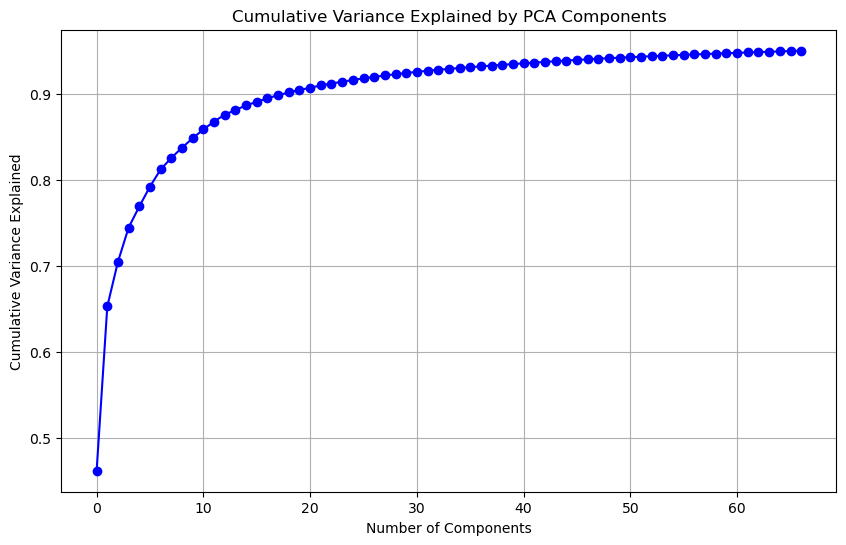

In [26]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


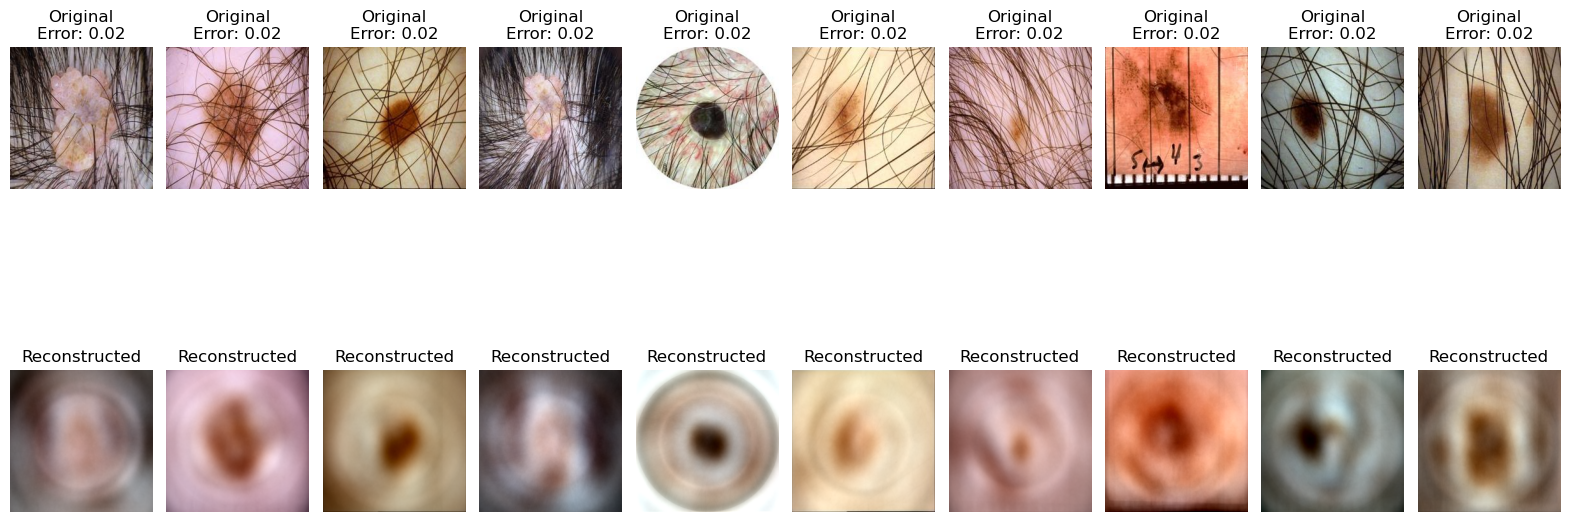

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_high_error_images(original_data, reconstructed_data, target_size=(IMG_HEIGHT, IMG_WIDTH), num_images=10):
    # Calculate reconstruction errors for each image
    errors = np.array([mean_squared_error(original.flatten(), reconstructed.flatten())
                       for original, reconstructed in zip(original_data, reconstructed_data)])
    
    # Find the indices of the images with the highest reconstruction errors
    high_error_indices = np.argsort(errors)[-num_images:]
    
    # Plotting
    fig, axes = plt.subplots(2, num_images, figsize=(20, 8))  # Adjust subplot to have 2 rows
    for i in range(num_images):
        # Original Image
        ax1 = axes[0, i]
        original_image = original_data[high_error_indices[i]].reshape(target_size[0], target_size[1], 3)
        ax1.imshow(original_image)
        ax1.set_title(f'Original\nError: {errors[high_error_indices[i]]:.2f}')
        ax1.axis('off')

        # Reconstructed Image
        ax2 = axes[1, i]
        reconstructed_image = reconstructed_data[high_error_indices[i]].reshape(target_size[0], target_size[1], 3)
        ax2.imshow(reconstructed_image)
        ax2.set_title('Reconstructed')
        ax2.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

    return high_error_indices, errors[high_error_indices]

# Example usage:
# Assuming `data` and `reconstructed_data` are your original and PCA-reconstructed datasets, respectively
high_error_indices, high_errors = plot_high_error_images(X_train_reshaped, reconstructed_images_reshaped, num_images=10)


In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,       
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    shear_range=0.2,          
    zoom_range=[0.9,1.1],     
    horizontal_flip=True,     
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    channel_shift_range=0.1,
    fill_mode='nearest'       # Strategy for filling newly created pixels
)



# Initialize the ImageDataGenerator for testing (usually with less or no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values
)

# Create generators that will read images from the directory and process them
# Assuming the generator is for a binary classification setup with one-hot encoding
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',  # This should be 'categorical' for softmax with 2 outputs,
    save_to_dir='./archive/augmented_train/',  # specify where to save the generated images
    save_prefix='aug',       # prefix for saved images
    save_format='png'
    
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'  # This should also be 'categorical'
)



Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Data Augmentation:

In [82]:
# Create an instance of ImageDataGenerator with desired augmentations
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

# Create directory structure if not exists
augmented_train_dir = './archive/augmented_train/'  
class_names = ['Benign', 'Malignant']
for cls in class_names:
    os.makedirs(os.path.join(augmented_train_dir, cls), exist_ok=True)

def augment_images(class_name, num_samples):
    source_dir = os.path.join(train_dir, class_name)
    target_dir = os.path.join(augmented_train_dir, class_name)
    
    # Create a generator for the images
    generator = datagen.flow_from_directory(
        train_dir,
        classes=[class_name],
        target_size=(224, 224),  # Adjust size to your requirement
        batch_size=32,
        class_mode='binary',  # Adjust based on your use case
        save_to_dir=target_dir,
        save_prefix='aug',
        save_format='jpg'
    )
    
    # Generate augmented images
    for i in range(num_samples):
        next(generator)

# Number of samples you want to augment per class
num_samples = 10  # Adjust this number based on your needs

# Augment images for each class
for class_name in class_names:
    augment_images(class_name, num_samples)

Found 6289 images belonging to 1 classes.
Found 5590 images belonging to 1 classes.


# Loading in the augmented images

In [83]:
X_train_aug, y_train_aug = load_images(augmented_train_dir)


Found 640 images belonging to 3 classes.


Loading images: 100%|██████████| 640/640 [00:00<00:00, 873.99images/s]


In [88]:
len(np.vstack((X_train, X_train_aug)))

12519

In [44]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Previous layers...
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(224, 224, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Change this to 2 units with softmax
])

# Compile the model for categorical crossentropy, suitable for one-hot encoded labels
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Changed to categorical crossentropy
              metrics=['accuracy'])


model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 216, 216, 16)   │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 214, 214, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 732736)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │    73,273,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,287,614 (279.57 MB)

 Trainable params: 73,287,614 (279.57 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
X_array = np.array(X_train)

In [46]:
# Retrain the model with the corrected configuration
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/371 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - accuracy: 0.6465 - loss: 1.3638 - val_accuracy: 0.5685 - val_loss: 0.7018
Epoch 2/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 350us/step - accuracy: 0.6875 - loss: 0.5443 - val_accuracy: 0.5000 - val_loss: 0.6768
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


371/371 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.6640 - loss: 0.6039 - val_accuracy: 0.5741 - val_loss: 0.6713
Epoch 4/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step - accuracy: 0.6562 - loss: 0.5481 - val_accuracy: 0.5000 - val_loss: 0.6647
Epoch 5/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - accuracy: 0.6730 - loss: 0.5860 - val_accuracy: 0.6316 - val_loss: 0.6338


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)))

    # Tuning the number of convolutional layers
    num_layers = hp.Int('num_conv_layers', 3, 5)

    # Starting with a base number of filters
    initial_filters = hp.Int('initial_filters', min_value=32, max_value=64, step=16)
    increase_factor = hp.Choice('increase_factor', [1, 1.25, 1.5])  # More granular control over increase

    filters = initial_filters  # Initialize filters to the initial value
    for i in range(num_layers):
        # Incrementally increase the number of filters based on the layer depth
        model.add(keras.layers.Conv2D(
            filters=filters,
            kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5]),
            activation='relu',
            padding='same'
        ))

        # Update filters for the next layer if not the last layer
        if i < num_layers - 1:
            filters = int(filters * increase_factor)
            filters = min(filters, 256)  # Ensure that filters do not exceed 256
        if hp.Choice(f'pooling_{i}', ['max', 'avg']) == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=2))
        else:
            model.add(keras.layers.AveragePooling2D(pool_size=2))

    model.add(keras.layers.Flatten())

    # Tuning the number of units in the dense layer
    model.add(keras.layers.Dense(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        activation='relu'
    ))

    model.add(keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(10, activation='softmax'))  # Adjust the output layer based on your dataset

    # Compiling the model
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Setting up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set more trials for a more thorough search
    executions_per_trial=3,
    directory='my_dir',
    project_name='keras_tuner_cnn'
)

# Load your data here
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# Start the search for the best hyperparameter configuration
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Number of Convolutional Layers: {best_hps.get('num_conv_layers')}
- Filters per Convolutional Layer: {[best_hps.get(f'filters_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Kernel Sizes: {[best_hps.get(f'kernel_size_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Pooling Types: {[best_hps.get(f'pooling_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Dense Layer Units: {best_hps.get('units')}
- Dropout Rate: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=50, validation_split=0.2)
